In [2]:
import sys, os
sys.path.append(os.path.join(os.path.dirname('__file__'), '..', 'DB_and_Azure'))
import sql_db_functions as SQLf

### get data from server

In [3]:
conn, cursor = SQLf.sql_db_functions.connect_sql()

In [4]:
query = "SELECT product_characteristics.id, Brand_id , Detail, Summary, Brand FROM product_characteristics INNER JOIN Products ON product_characteristics.Brand_id = Products.Brand_Prod_id ;"
cursor.execute(query)

# Fetch the rows
rows = cursor.fetchall()
rows[0]

(161,
 1,
 '    *Type: Shirt\n    *Fit: Regular fit\n    *Sleeve style: Long sleeve\n    *Neckline: Collared\n    *Material: Silk\n    *Formality: Business Casual\n    *Season: Autumn, Spring, Summer\n    *Colors: Navy (70%), White (30%)\n    *Texture: Smooth\n    *Transparency: Opaque\n    *Details and Embellishments: Buttons\n    *Shape: Fitted\n    *Length: Hip-length\n    *Collar Style: Button-down\n    *Sleeve Style: Long\n    *Patterns: Geometric\n    *Patterns placement: All-over\n    *Fluidity of fabric: High\n    *Fabric weight: Light\n    *Pocket Presence: No\n    *Pocket placement: Not applicable\n    *Pocket size: Not applicable\n    *Breathability: High\n    *Occasion Suitability: Business Casual, Formal\n    *Lapel: Not applicable',
 'The item is a Gucci silk shirt featuring an optical GG monogram print. It is designed with a regular fit and features long sleeves with buttoned cuffs. The neckline is a classic pointed collar, adding a touch of formality. The material used 

In [5]:
conn, cursor = SQLf.sql_db_functions.connect_sql()

In [6]:
query = "SELECT Brand_id, base64 FROM product_img ;"
cursor.execute(query)

# Fetch the rows
rows_img = cursor.fetchall()
#rows_img

In [7]:
len(rows_img)

212

In [8]:
SQLf.sql_db_functions.close_connection_db(conn=conn,cursor=cursor)

### organize data

In [9]:
import pandas as pd

In [10]:
df = pd.DataFrame(rows ,columns= ['Id','prod_id','descripcion', 'Summary','Brand'])

In [11]:
df.head()

,Id,prod_id,descripcion,Summary,Brand
0,161,1,*Type: Shirt\n *Fit: Regular fit\n *...,The item is a Gucci silk shirt featuring an op...,Gucci
1,162,2,*Type: Shirt \n*Fit: Regular fit \n*Sleeve s...,The Gucci cotton Oxford GG shirt with an optic...,Gucci
2,163,3,*Type: Cropped blouse \n*Fit: Regular fit \n...,The Gucci top is a cropped blouse made of luxu...,Gucci
3,164,4,*Type: Shirt \n*Fit: Regular fit \n*Sleeve s...,The garment in question is a Gucci Camicia in ...,Gucci
4,165,5,*Type: Shirt \n*Fit: Regular fit \n*Sleeve s...,The garment in question is a Gucci cotton popl...,Gucci


In [12]:
df['descripcion'] = df['descripcion'].str.replace('\n*', ' / ')
df['descripcion'] = df['descripcion'].str.replace(r'\s+', ' ')
df['descripcion'] = df['descripcion'].str.replace('*', ' ')

df.head(5)

,Id,prod_id,descripcion,Summary,Brand
0,161,1,Type: Shirt\n Fit: Regular fit\n ...,The item is a Gucci silk shirt featuring an op...,Gucci
1,162,2,Type: Shirt / Fit: Regular fit / Sleeve s...,The Gucci cotton Oxford GG shirt with an optic...,Gucci
2,163,3,Type: Cropped blouse / Fit: Regular fit /...,The Gucci top is a cropped blouse made of luxu...,Gucci
3,164,4,Type: Shirt / Fit: Regular fit / Sleeve s...,The garment in question is a Gucci Camicia in ...,Gucci
4,165,5,Type: Shirt / Fit: Regular fit / Sleeve s...,The garment in question is a Gucci cotton popl...,Gucci


In [13]:
df['Complete_description'] = df['Summary'] + ' /' + "Brand: " + df['Brand'] + " /" + df['descripcion']
df.head()

,Id,prod_id,descripcion,Summary,Brand,Complete_description
0,161,1,Type: Shirt\n Fit: Regular fit\n ...,The item is a Gucci silk shirt featuring an op...,Gucci,The item is a Gucci silk shirt featuring an op...
1,162,2,Type: Shirt / Fit: Regular fit / Sleeve s...,The Gucci cotton Oxford GG shirt with an optic...,Gucci,The Gucci cotton Oxford GG shirt with an optic...
2,163,3,Type: Cropped blouse / Fit: Regular fit /...,The Gucci top is a cropped blouse made of luxu...,Gucci,The Gucci top is a cropped blouse made of luxu...
3,164,4,Type: Shirt / Fit: Regular fit / Sleeve s...,The garment in question is a Gucci Camicia in ...,Gucci,The garment in question is a Gucci Camicia in ...
4,165,5,Type: Shirt / Fit: Regular fit / Sleeve s...,The garment in question is a Gucci cotton popl...,Gucci,The garment in question is a Gucci cotton popl...


In [14]:
documents = df['Complete_description'].tolist()
id = df['Id'].astype('str').tolist()
metadata = [{"source": id} for id in df['Id'].astype('str').tolist()]

In [15]:
df_image = pd.DataFrame(rows_img, columns=['prod_id', 'base64'])

In [16]:
df_image.head(2)

,prod_id,base64
0,1,"data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAAQ..."
1,1,"data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAAQ..."


In [17]:
df_image.shape

(212, 2)

In [18]:
del rows, rows_img

### Get images 

In [19]:
import base64
from io import BytesIO
from PIL import Image

In [20]:
def base64_to_image(base64_string):
    # Remove the data URI prefix if present
    if "data:image" in base64_string:
        base64_string = base64_string.split(",")[1]

    # Decode the Base64 string into bytes
    image_bytes = base64.b64decode(base64_string)
    return image_bytes

In [21]:
def create_image_from_bytes(image_bytes):
    # Create a BytesIO object to handle the image data
    image_stream = BytesIO(image_bytes)

    # Open the image using Pillow (PIL)
    image = Image.open(image_stream)
    return image

In [22]:
def resize_image(image, new_width):
    # Open the image

    # Calculate the new height while maintaining the aspect ratio
    original_width, original_height = image.size
    aspect_ratio = original_height / original_width
    new_height = int(new_width * aspect_ratio)

    # Resize the image
    resized_image = image.resize((new_width, new_height), Image.ANTIALIAS)

    return resized_image


In [23]:
df_image.iloc[200].base64

'data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQgJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAjKBwgDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD1qiiigAopaSgApaKKACiiigAooooAKKKKAFopKWgAooooAKKKWgAo70lLQAUlLRQAUUUUAFFFFABRRRQAUUUUAFLSUtABS0lLQAUtJS0AHejiiigAooooAKKKKACiij0oABRRRQAUUUUAFFL

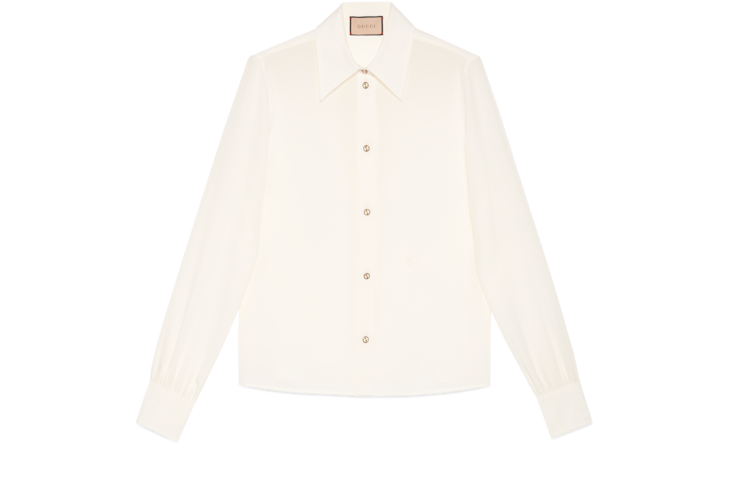

In [24]:
image_bytes = base64_to_image(df_image.iloc[42].base64)
create_image_from_bytes(image_bytes=image_bytes)

### Testing embeddings

In [25]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.retrievers.multi_vector import MultiVectorRetriever

In [26]:
from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings,
)

In [27]:
embedding_function = SentenceTransformerEmbeddings(model_name='all-mpnet-base-v2')

c:\Users\juand\anaconda3\Lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
c:\Users\juand\anaconda3\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
c:\Users\juand\anaconda3\Lib\site-packages\transformers\utils\generic.py:482: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
c:\

### organized text 

In [28]:
df = pd.merge(
            df,
            df_image.groupby('prod_id')['base64'].apply(list).reset_index(),
            on='prod_id'
        )

In [29]:
df.prod_id = df.prod_id.astype(int)
df.sort_values('prod_id',ascending=True,inplace=True)
df.reset_index(drop=True, inplace= True)
df.prod_id = df.prod_id.astype('string')
df.head(5)

,Id,prod_id,descripcion,Summary,Brand,Complete_description,base64
0,161,1,Type: Shirt\n Fit: Regular fit\n ...,The item is a Gucci silk shirt featuring an op...,Gucci,The item is a Gucci silk shirt featuring an op...,"[data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA..."
1,162,2,Type: Shirt / Fit: Regular fit / Sleeve s...,The Gucci cotton Oxford GG shirt with an optic...,Gucci,The Gucci cotton Oxford GG shirt with an optic...,"[data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA..."
2,163,3,Type: Cropped blouse / Fit: Regular fit /...,The Gucci top is a cropped blouse made of luxu...,Gucci,The Gucci top is a cropped blouse made of luxu...,"[data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA..."
3,164,4,Type: Shirt / Fit: Regular fit / Sleeve s...,The garment in question is a Gucci Camicia in ...,Gucci,The garment in question is a Gucci Camicia in ...,"[data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA..."
4,165,5,Type: Shirt / Fit: Regular fit / Sleeve s...,The garment in question is a Gucci cotton popl...,Gucci,The garment in question is a Gucci cotton popl...,"[data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA..."


### chunks

In [30]:
df = df[['prod_id', 'Summary','Brand','base64']]._append(df[['prod_id', 'descripcion','Brand','base64']].rename(columns = {'descripcion':'Summary'}),ignore_index=True)

In [32]:
df.Brand.unique()

array(['Gucci', 'HM', 'Mango', 'Prada'], dtype=object)

In [44]:
df = df[(df.Brand != 'Gucci') & (df.Brand != 'Prada')  ]
df.reset_index(inplace=True,drop=True)

In [45]:
df.head()

,prod_id,Summary,Brand,base64
0,14,"The shirt in the images is a contemporary, cas...",HM,"[data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA..."
1,15,"The shirt featured in the images is a casual, ...",HM,"[data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA..."
2,16,The shirt depicted in the images is a casual y...,HM,"[data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA..."
3,17,The garment depicted in the images is a women'...,HM,"[data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA..."
4,18,The garment is a casual women's long-sleeve sh...,HM,"[data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAA..."


In [46]:
persist_directory = '../../../Chromadb/chroma-retail'

In [47]:
store = InMemoryStore()
id_key = 'doc_id'

In [48]:
min(df['base64'].apply(lambda x: len(x)))

2

In [49]:
def return_none(x):

    if x == None: return 'None'
    
    return x

In [50]:
doc_ids = df.prod_id


texts = [
    Document(
        page_content= df.iloc[i].Summary, 
        metadata={
            id_key:df.iloc[i].prod_id,
            "img_1": return_none( df.iloc[i].base64[0] ),
            "img_2": return_none( df.iloc[i].base64[1] )  
            }
    )
    for i in df.index
]


In [51]:
vectorstore = Chroma.from_documents(
                documents=texts,
                #ids=doc_ids,
                embedding=embedding_function,
                collection_name='multi_modal_rag',
                #metadatas=metadata,
                persist_directory=persist_directory
            )

In [52]:
vectorstore.similarity_search('HM')[0].page_content

'The garment is a long-sleeve button-up shirt featuring a relaxed fit that drapes comfortably over the body, making it suitable for both casual and semi-formal occasions. The shirt has a classic pointed collar and a V-neckline that adds a touch of sophistication. Made from a lightweight and breathable fabric, likely a blend of cotton and polyester, it offers a soft and smooth texture with a slight sheen. The main color is a deep navy blue, which provides a versatile and timeless look, complemented by subtle white pinstripes running vertically, adding a refined and elongating effect to the overall design. The sleeves are long and slightly loose, ending in buttoned cuffs for an adjustable fit. The shirt has no visible pockets, contributing to its sleek and clean aesthetic. The length of the shirt, approximately 79.5 cm for size M, allows it to be worn tucked in or out, enhancing its adaptability for different styles and seasons. There are no additional embellishments or patterns, ensurin

### Already loaded !!!

In [133]:
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
    search_kwargs={"k":5}
)

In [134]:
docs = retriever.invoke(
    "HM"
)

In [135]:
docs

[]

In [81]:
retriever.vectorstore.add_documents(texts)
#retriever.docstore.mset(list(zip(doc_ids, texts)))

['7a9c62e2-ad7d-44e7-94b9-2388200a13aa',
 '56fbcfda-91f7-48c2-968c-2d0235550aa6',
 '6b2b763b-5dce-402c-aade-52276ee5da93',
 '5241d80c-6a64-4d76-9fb4-28dd10f60f6b',
 'c6916f49-9231-41fc-b535-2c0f93efab8a',
 '4eace965-d9ec-42c2-8589-1630b423066e',
 '92079cd6-c445-4483-a8c8-1af681080d26',
 'd41ed153-1669-4203-bfca-bd2ebf7e10a6',
 'c9baaf42-aaa8-4d8b-8c21-4156bbe224f4',
 'c2390981-10cd-4e6c-8d90-4e2318372388',
 '4e70821c-f46f-4c9c-8394-cad65f66f708',
 'ccb68549-0cde-478b-805e-dcb5bd218422',
 '4b9a8b25-9616-4f79-a1cb-726a3349104b',
 'e075a918-deb9-49d5-8166-0ceaaf3a97cc',
 'dbfbb44e-b0cb-4337-a108-03890e2a8e45',
 '04df9707-cb4f-470f-ba32-e4296936572c',
 'b498324e-048a-4db7-85db-1f25bb458e1c',
 '898ada7d-164a-4f74-b12d-89698529821f',
 '029e3b7a-ff94-42a9-ad79-9059c90a9591',
 '48102b5d-d098-42cc-bd7f-fac2b74f7fe0',
 'deeb9bc3-885f-457e-a72a-7911d9711738',
 'd010d8ff-c0f9-4460-b908-817903b87b10',
 'c21c6ad1-4191-433b-9502-9942c58d68d7',
 'fb57b166-9750-4d09-9528-dfc22f704717',
 '3c0485ff-70f5-

In [136]:
docs = retriever.invoke(
    "HM"
)

In [137]:
docs

[]

In [ ]:
df.iloc[1].Complete_description

'The Gucci cotton Oxford GG shirt with an optical effect features a tailored fit that accentuates a modern silhouette, making it suitable for both formal and semi-formal occasions. This long-sleeve shirt showcases a classic button-down front and a standard collar, contributing to its timeless appeal. Crafted from high-quality Oxford cotton, the material offers a medium weight, providing comfort and breathability suitable for all seasons. The shirt prominently displays the iconic GG monogram in a repeated pattern, creating an optical illusion effect that adds a contemporary twist to the classic fabric. The primary color of the shirt is a rich navy blue, which serves as the base for the intricate light blue GG pattern. This pattern is consistently placed across the entire garment, ensuring a cohesive and polished look. Additional details include a single chest pocket, perfectly sized and positioned for both functionality and style. The fabric has a smooth texture with minimal transparenc

### Talk to Chroma

In [40]:
from apikey import apikey 
from langchain.chat_models import ChatOpenAI

In [41]:
os.environ['OPENAI_API_KEY'] = apikey

In [42]:
turbo_llm = ChatOpenAI(
    temperature=0,
    model_name='gpt-3.5-turbo'
)

c:\Users\juand\anaconda3\Lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [80]:
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

### lets set up the system

from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate

In [81]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [111]:
system_prompt = (
    "You are a Fashion specialist engine to sugest clothing pieces from context. "
    "If you don't know the answer to the question, say that you dont know "
    "answer concise."
    #"Explain why the selected options of the context are the best ones"
    "\n\n"
    "{context}"
)

In [112]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

In [113]:
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | turbo_llm
    | StrOutputParser()
)

In [114]:
question_answer_chain = create_stuff_documents_chain(turbo_llm, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

In [116]:
query = "Im looking for clothing peaces from Mango that could be similar to Gucci clothing"

In [117]:
response = rag_chain.invoke({"input": query})
print(response["answer"])

I don't know the answer to that question.


In [118]:
for document in response["context"]:
    print(document)
    print()

page_content='The garment is a straight-cut shirt made from 100% lyocell, which lends it a smooth, fluid texture and good breathability, ideal for spring and summer wear. The fit is relaxed and loose, providing comfort and ease of movement. It features long sleeves with buttoned cuffs, enhancing its versatility for both casual and slightly formal occasions. The neckline is a classic shirt collar, giving it a polished look. The shirt is designed in a solid, neutral beige color, which is versatile and easy to pair with various outfits. The beige hue is warm and subdued, making it suitable for both daytime and evening wear. The fabric appears lightweight and soft, draping elegantly over the body without being transparent. There are no visible pockets, embellishments, or patterns, which maintains the shirt’s clean and minimalist aesthetic. This shirt is suitable for casual outings, office wear, or laid-back social gatherings, offering a blend of style and comfort. /Brand: Mango / Type: Shi

In [119]:
df_image[df_image.prod_id == 41]

,prod_id,base64
115,41,"data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAAQ..."
116,41,"data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAAQ..."
117,41,"data:image/jpeg;base64, /9j/4AAQSkZJRgABAQAAAQ..."


In [123]:
image_bytes = base64_to_image(df_image.iloc[113].base64)
img = create_image_from_bytes(image_bytes=image_bytes)
img.resize((400,500))